## Evaluating quantum kernel matrices and solve a simple regression task

This notebook shows how to use sQUlearn to evaluate a fidelity quantum kernel (FQK)

$$
k(x,x')^Q = |\braket{\psi(x)|\psi(x')}|^2
$$

or a projected quantum kernel (PQK) of the form
$$
    k(x,x')^{PQ} = \exp\left(-\gamma\sum_k\sum_{P\in\lbrace X,Y,Z\rbrace}[\mathrm{tr}(P\varrho(x)_k) - \mathrm{tr}(P\varrho(x')_k)]^2\right) = \exp\left(-\gamma[\mathrm{QNN}(x) - \mathrm{QNN}(x')]^2\right)
$$
The quantum encoding circuit/ parameterized quantum circuit to obtain both FQK and QNN is chosen to be the Chebyshev polynomial encoding circuit. The trainable parameters of the quantum encoding circuit are sampled randomly. The training kernel matrix is evaluated for a simple toy function and the corresponding regression task is solved using QKRR. Finally, the results are plotted and the MSE score is evaluated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.kernel.lowlevel_kernel import ProjectedQuantumKernel, FidelityKernel
from squlearn.kernel import QKRR

In [2]:
# Generate data set (analogously to qgpr_workflow.ipynb example)
def func(x):
    return np.sin(3 * x) * x * x


# define training and test data
x = np.linspace(-1, 1, 100)
y = func(x)
x_train = np.linspace(-1, 1, 15)
y_train = func(x_train)

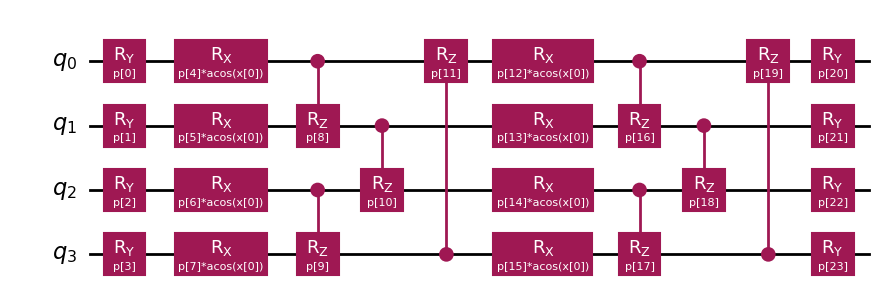

In [3]:
# set up encoding circuit with trainable parameters being randomly initialized
enc_circ = ChebyshevPQC(num_qubits=4, num_layers=2)
enc_circ.draw(output="mpl", num_features=1)

In [4]:
# now we can define the kernel
# we can either use the ProjectedQuantumKernel or the FidelityKernel

# Randomly sample variational parameters of encoding circuit
np.random.seed(0)
param = np.random.rand(enc_circ.num_parameters)

# Initialize Executor for quantum circuit execution
executor = Executor()

# Note: That variational parameters of encoding circuit are passed to Kernel definition
q_kernel_pqk = ProjectedQuantumKernel(
    encoding_circuit=enc_circ,
    executor=executor,
    measurement="XYZ",
    outer_kernel="gaussian",
    initial_parameters=param,
    gamma=2.0,
)

# 2.Option: FidelityKernel
q_kernel_fqk = FidelityKernel(
    encoding_circuit=enc_circ, executor=executor, initial_parameters=param
)

In [5]:
# now we can basically use any qml kernel method
# Example: QKRR
qkrr_pqk = QKRR(quantum_kernel=q_kernel_pqk, alpha=1e-5)
qkrr_pqk.fit(x_train.reshape(-1, 1), y_train)
y_pred_pqk = qkrr_pqk.predict(x.reshape(-1, 1))

qkrr_fqk = QKRR(quantum_kernel=q_kernel_fqk, alpha=1e-5)
qkrr_fqk.fit(x_train.reshape(-1, 1), y_train)
y_pred_fqk = qkrr_fqk.predict(x.reshape(-1, 1))

MSE PQK KRR:  1.7682770859963323e-05
MSE FQK KRR:  0.0003174915520682164


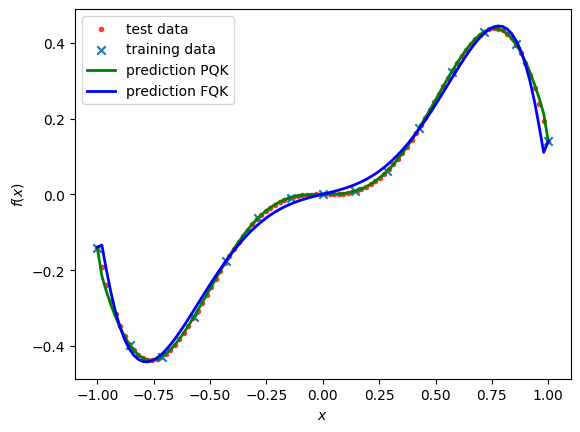

In [6]:
from sklearn.metrics import mean_squared_error

print("MSE PQK KRR: ", mean_squared_error(y, y_pred_pqk))
print("MSE FQK KRR: ", mean_squared_error(y, y_pred_fqk))

# Plot the results
# plot result
plt.scatter(x.reshape(-1, 1), y, marker=".", label="test data", color="red", alpha=0.7)
plt.scatter(x_train, y_train, marker="x", label="training data")
plt.plot(x, y_pred_pqk, linewidth=2, color="green", label="prediction PQK")
plt.plot(x, y_pred_fqk, linewidth=2, c="b", label="prediction FQK")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()